In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import esmlab
from glob import glob
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
import esmlab
import warnings
warnings.filterwarnings('ignore')
import ncar_jobqueue
from dask.distributed import Client
import cmocean
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath

### Observations GLODAP

In [2]:
ds = xr.open_mfdataset('/glade/work/kristenk/GLODAPv2_regridded/*.nc',decode_times=False,decode_coords=False)
ds = ds.rename({'depth_surface':'depth'})

In [3]:
ds.TAlk

<xarray.DataArray 'TAlk' (depth: 33, lat: 180, lon: 360)>
dask.array<open_dataset-1bba0a90c04574536a08fe0683569401TAlk, shape=(33, 180, 360), dtype=float32, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

In [4]:
Alk3=(ds.TAlk + 1.36 * ds.NO3)/ ds.salinity * 35

In [5]:
mean_tropAlk=Alk3.isel(depth=slice(0,3), lat=slice(60,120))
mean_tropAlk=mean_tropAlk.mean(dim='depth')
mean_tropAlk=mean_tropAlk.mean() 
#mean_tropAlk is 2300.4065

In [6]:
Alk_star=Alk3 - mean_tropAlk
ds['Alk_star'] = xr.DataArray(Alk_star,dims=('depth','lat','lon'))
ds['sPAlk'] = xr.DataArray(Alk3,dims=('depth','lat','lon'))

In [7]:
na = np.newaxis
pressure = sw.eos80.pres(ds.depth.values[:,na,na],ds.lat.values[na,:,na])
pDensity = sw.pden(ds.salinity, ds.temperature, pressure)-1000.

In [8]:
density =  sw.dens(ds.salinity, ds.temperature, pressure)

In [9]:
ds['density'] = xr.DataArray(density,dims=('depth','lat','lon'))

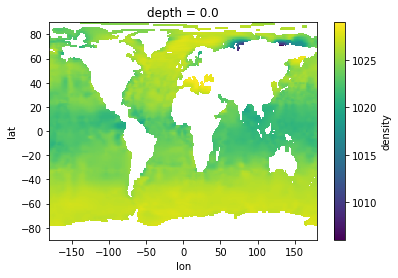

In [10]:
ds.density.isel(depth=0).plot()

In [11]:
ds['sPAlk_mmolm3'] = ds.sPAlk * density * 0.001 #converting from micromol/m3 to mmol/m3

In [12]:
ds['pdens'] = xr.DataArray(pDensity,dims=('depth','lat','lon'))

In [13]:
area = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

In [14]:
j=0

for lat in ds.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds['area']=area

In [15]:
def interp3d(coord_field,ds,new_levels,dim,**kwargs):
    '''kludged function for interpolation
    '''

    method = kwargs.pop('method','linear')
    if method == 'linear':
        from metpy.interpolate import interpolate_1d
        interp_func = interpolate_1d
    elif method == 'log':
        from metpy.interpolate import log_interpolate_1d
        interp_func = log_interpolate_1d

    newdim = new_levels.dims[0]

    dso = xr.Dataset()
    for v in ds.variables:

        if dim not in ds[v].dims:
            dso[v] = ds[v]
        else:

            dims_in = ds[v].dims
            if len(dims_in) == 1: continue

            interp_axis = dims_in.index(dim)
            dims_out = list(dims_in)
            dims_out[interp_axis] = newdim

            dso[v] = xr.DataArray(
                interp_func(new_levels.values,
                            coord_field.values,ds[v].values,axis=interp_axis),
                dims=dims_out,attrs=ds[v].attrs)
    dso[newdim] = new_levels
    return dso

In [16]:
sigma_coord = xr.DataArray(np.arange(25., 28., 0.1),dims='sigma')
ds_sigma = interp3d(ds.pdens,ds,sigma_coord,'depth',method='linear')

In [17]:
ds_sigma

<xarray.Dataset>
Dimensions:                 (lat: 180, lon: 360, sigma: 30)
Coordinates:
  * lat                     (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                     (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * sigma                   (sigma) float64 25.0 25.1 25.2 ... 27.7 27.8 27.9
Data variables:
    Cant                    (sigma, lat, lon) float64 nan nan nan ... nan 26.08
    CantInput_mean          (sigma, lat, lon) float64 nan nan nan ... nan nan
    NO3                     (sigma, lat, lon) float64 nan nan ... 12.09 12.46
    NO3Input_mean           (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaA                  (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaAInput_mean        (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaC                  (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaCInput_mean        (sigma, lat, lon) float64 nan nan nan ... nan nan
    PI_TCO2                 (sigma, lat, lon) float64 nan nan ... 2.136e+03
    PI_TCO2Input_mean       (sigma, lat, lon) float64 nan nan nan ... nan nan
    PO4                     (sigma, lat, lon) float64 nan nan ... 0.8614 0.892
    PO4Input_mean           (sigma, lat, lon) float64 nan nan nan ... nan nan
    TAlk                    (sigma, lat, lon) float64 nan nan ... 2.291e+03
    TAlkInput_mean          (sigma, lat, lon) float64 nan nan nan ... nan nan
    TCO2                    (sigma, lat, lon) float64 nan nan ... 2.162e+03
    TCO2Input_mean          (sigma, lat, lon) float64 nan nan nan ... nan nan
    oxygen                  (sigma, lat, lon) float64 nan nan ... 308.6 308.0
    oxygenInput_mean        (sigma, lat, lon) float64 nan nan nan ... nan nan
    pHts25p0                (sigma, lat, lon) float64 nan nan ... 7.696 7.697
    pHts25p0Input_mean      (sigma, lat, lon) float64 nan nan nan ... nan nan
    pHtsinsitutp            (sigma, lat, lon) float64 nan nan nan ... nan nan
    pHtsinsitutpInput_mean  (sigma, lat, lon) float64 nan nan nan ... nan nan
    salinity                (sigma, lat, lon) float64 nan nan ... 34.72 34.72
    salinityInput_mean      (sigma, lat, lon) float64 nan nan nan ... nan nan
    silicate                (sigma, lat, lon) float64 nan nan nan ... nan 7.709
    silicateInput_mean      (sigma, lat, lon) float64 nan nan nan ... nan nan
    temperature             (sigma, lat, lon) float64 nan nan ... -0.3432
    temperatureInput_mean   (sigma, lat, lon) float64 nan nan nan ... nan nan
    Alk_star                (sigma, lat, lon) float64 nan nan ... 26.39 26.96
    sPAlk                   (sigma, lat, lon) float64 nan nan ... 2.327e+03
    density                 (sigma, lat, lon) float64 nan nan ... 1.033e+03
    sPAlk_mmolm3            (sigma, lat, lon) float64 nan nan ... 2.404e+03
    pdens                   (sigma, lat, lon) float64 nan nan nan ... 27.9 27.9
    area                    (lat, lon) float64 216.3 216.3 ... -1.281e-09

### Get PIC observations

In [18]:
picfile = '/glade/work/kristenk/satellite_data/processed/mean_PIC_annual_2002-2017_molm3.nc'
#picfile = '/glade/work/kristenk/satellite_data/cumulative_mean_pic/A20021852019334.L3m_CU_PIC_pic_9km.nc'
ds_pic = xr.open_dataset(picfile,decode_times=False,decode_coords=False)
ds_pic = ds_pic.rename({'z':'pic'})

In [19]:
picfile = '/glade/work/kristenk/satellite_data/cumulative_mean_pic/A20021852019334.L3m_CU_PIC_pic_9km.nc'
ds_pic2 = xr.open_dataset(picfile,decode_times=False,decode_coords=False)

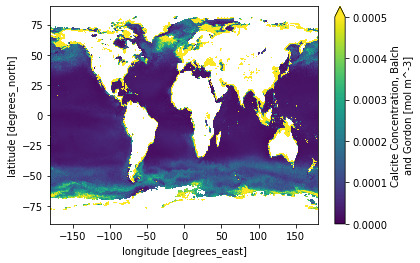

In [20]:
ds_pic.pic.plot(vmin=0,vmax=0.0005)

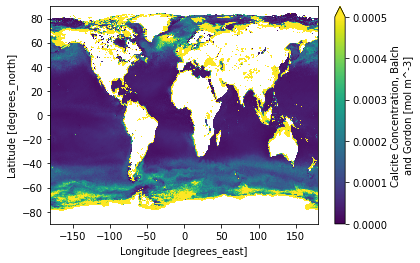

In [21]:
ds_pic2.pic.plot(vmin=0,vmax=0.0005)

In [22]:
sstfile = '/glade/work/kristenk/satellite_data/processed/mean_SST_annual_2002-2017.nc'
ds_sst = xr.open_dataset(sstfile,decode_times=False,decode_coords=False)
ds_sst = ds_sst.rename({'z':'sst'})

In [23]:
ds_sigma.sigma[18]

<xarray.DataArray 'sigma' ()>
array(26.8)
Coordinates:
    sigma    float64 26.8

In [24]:
MW2_sPAlk = ds_sigma.sPAlk_mmolm3.isel(sigma=slice(10,21)).mean(dim='sigma')

In [25]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

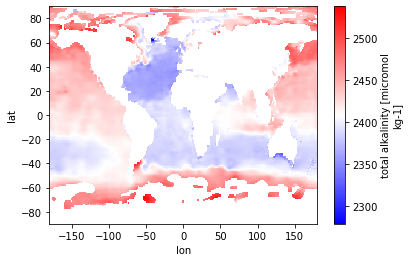

In [26]:
MW2_sPAlk.plot(cmap='bwr')

## CESM

### Get coords

In [27]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
#ds_woa['z_t'] = ds_annmean.z_t

lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
#ds_woa

### Get noGCB dataset

In [28]:
# case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
# path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
# coords = {'x':'TLONG','y':'TLAT'}
# keepthese = ['z_t','z_t_150m','time_bound','TAREA','NO3','coccoCaCO3','SALT','ALK','ALK_ALT_CO2','TEMP']
# keep_vars = keepthese +list(coords.values())+['dz','KMT']

In [29]:
# %%time
# ds_list = []
# print(f'reading {case}')
# cesm_mon_ds = xr.Dataset()
# for v in variables:
    
#     print(v)   
#     files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       
#     dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
#                        drop_variables=["transport_components", "transport_regions"], decode_times=True)

#     cesm_mon_ds = xr.merge((cesm_mon_ds, dsv))
#     ds_list.append(cesm_mon_ds)

In [30]:
# cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [31]:
# %%time
# ds_annmean=cesm_mon_ds.mean(dim='time').compute()

In [32]:
#write out annual means
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/annual_means.nc'
#ds_annmean.to_netcdf(outfile)
ds_annmean=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [33]:
ds_annmean

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (d2) float64 ...
    dz           (z_t) float32 ...
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    KMT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    TEMP         (z_t, nlat, nlon) float32 ...
    SALT         (z_t, nlat, nlon) float32 ...
    NO3          (z_t, nlat, nlon) float32 ...
    ALK          (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 ...
    coccoCaCO3   (z_t_150m, nlat, nlon) float32 ...
Attributes:
    title:             cesm22cocco.G1850ECOIAF.T62_g17.003
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-01-29 at 09:50:39.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### CESM with 2x calc ALK

### Now add the 2xGCB vars to the dataset

In [34]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_pd_004.nc'
#ds_annmean2x.to_netcdf(outfile)
ds_tmp = xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [35]:
ds_annmean['PD'] = ds_tmp['PD']

In [36]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_alkalt_004.nc'
#ds_annmean2x.to_netcdf(outfile)
ds_tmp = xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [37]:
ds_annmean['ALK_2xGCB'] = ds_tmp['ALK_ALT_CO2']

In [38]:
ds_annmean

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (d2) float64 1.018e+05 1.018e+05
    dz           (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    KMT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    TEMP         (z_t, nlat, nlon) float32 ...
    SALT         (z_t, nlat, nlon) float32 ...
    NO3          (z_t, nlat, nlon) float32 ...
    ALK          (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 ...
    coccoCaCO3   (z_t_150m, nlat, nlon) float32 ...
    PD           (z_t, nlat, nlon) float32 ...
    ALK_2xGCB    (z_t, nlat, nlon) float32 ...
Attributes:
    title:             cesm22cocco.G1850ECOIAF.T62_g17.003
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-01-29 at 09:50:39.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Calculate sPAlk for control, noGCB, and 2xGCB

In [39]:
#control
#Alk3=(ds_annmean.ALK + 1.36 * ds_annmean.NO3)/ ds_annmean.SALT * 35.
Alk3=(ds_annmean.ALK)/ ds_annmean.SALT * 35. + 1.36 * ds_annmean.NO3
ds_annmean['sPAlk']=xr.DataArray(Alk3,dims=('z_t','nlat','nlon'))

In [40]:
#noGCB
#Alk3_alt=(ds_annmean.ALK_ALT_CO2 + 1.36 * ds_annmean.NO3)/ ds_annmean.SALT * 35.
Alk3_alt=(ds_annmean.ALK_ALT_CO2)/ ds_annmean.SALT * 35.  + 1.36 * ds_annmean.NO3
ds_annmean['sPAlk_noGCB']=xr.DataArray(Alk3_alt,dims=('z_t','nlat','nlon'))

In [41]:
#Alk3_alt_2x=(ds_annmean.ALK_2xGCB + 1.36 * ds_annmean.NO3)/ ds_annmean.SALT * 35.
Alk3_alt_2x=(ds_annmean.ALK_2xGCB)/ ds_annmean.SALT * 35.  + 1.36 * ds_annmean.NO3
ds_annmean['sPAlk_2xGCB']=xr.DataArray(Alk3_alt_2x,dims=('z_t','nlat','nlon'))

### Calculate sigma potential density

In [42]:
ds_annmean['PD_sigma']=ds_annmean.PD*1000.-1000

### Put the dataset onto sigma coordinates

In [43]:
sigma_coord = xr.DataArray(np.arange(25., 28., 0.1),dims='sigma')
ds_sigma_cesm = interp3d(ds_annmean.PD_sigma, ds_annmean, sigma_coord, 'z_t', method='linear')

In [44]:
ds_sigma_cesm.sigma[21]

<xarray.DataArray 'sigma' ()>
array(27.1)
Coordinates:
    sigma    float64 27.1

### Take sPAlk means over sigma range and get them ready to be plotted: sigma 26 to 27

In [45]:
temp_surf = ds_annmean.TEMP.isel(z_t=0)

In [46]:
MW2_sPAlk_cesm = ds_sigma_cesm.sPAlk.isel(sigma=slice(10,21)).mean(dim='sigma')
MW2_sPAlk_cesm_noGCB = ds_sigma_cesm.sPAlk_noGCB.isel(sigma=slice(10,21)).mean(dim='sigma')
MW2_sPAlk_cesm_2xGCB = ds_sigma_cesm.sPAlk_2xGCB.isel(sigma=slice(10,21)).mean(dim='sigma')

In [47]:
#2xGCB
lon, lat, field_spalk_2xGCB = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm_2xGCB.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_spalk_2xGCB = field_spalk_2xGCB[sh, :]

In [48]:
#CONTROL
lon, lat, field_spalk = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_spalk = field_spalk[sh, :]

In [49]:
#noGCB
lon, lat, field_spalk_noGCB = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm_noGCB.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_spalk_noGCB = field_spalk_noGCB[sh, :]

In [50]:
#CaCO3 surface
lon2, lat2, field_caco3 = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values, ds_annmean.coccoCaCO3.isel(z_t_150m=0).where(temp_surf>=2.))
sh = lat2[:, 0] < 0
lon2 = lon2[sh, :]
lat2 = lat2[sh, :]
field_caco3 = field_caco3[sh, :]

In [51]:
lon2, lat2, field_pd = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values, ds_annmean.PD_sigma.isel(z_t=0))
sh = lat2[:, 0] < 0
lon2 = lon2[sh, :]
lat2 = lat2[sh, :]
field_pd = field_pd[sh, :]

In [52]:
# i=0
# for long in np.arange(-180,180,1):
#     line30s[i,0]=long
#     line30s[i,1]=-30.
#     i = i+1
#     #print(lon)

In [53]:
lat_grd=np.empty([180,360])

In [54]:
for y in np.arange(0,180):
    lat_grd[y,:]=ds.lat[y]
    
    #print(x)

In [55]:
lat_grd

array([[-89.5, -89.5, -89.5, ..., -89.5, -89.5, -89.5],
       [-88.5, -88.5, -88.5, ..., -88.5, -88.5, -88.5],
       [-87.5, -87.5, -87.5, ..., -87.5, -87.5, -87.5],
       ...,
       [ 87.5,  87.5,  87.5, ...,  87.5,  87.5,  87.5],
       [ 88.5,  88.5,  88.5, ...,  88.5,  88.5,  88.5],
       [ 89.5,  89.5,  89.5, ...,  89.5,  89.5,  89.5]])

### Put all maps together

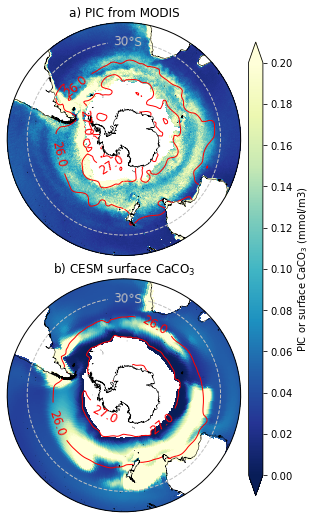

In [56]:
fig = plt.figure(figsize=(4,9))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')
alk_min=2380
alk_max=2450
contour_specs = {'levels': [26.0,27.0]}
lats_contour=[-60.,-45.,-30.,-15.,0.]

#---------- PIC from satellite
ax = fig.add_subplot(2,1,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

#################### make it a circle
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='silver',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '30°S'
plt.clabel(cs_lat, colors = 'silver', fmt = fmt, fontsize=12)
#########################

ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) PIC from MODIS')
pc=ax.pcolormesh(ds_pic.lon, ds_pic.lat, 
                 ds_pic.pic.where(ds_sst.sst>2.)*1000, vmin=0, vmax=0.2, cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mean annual PIC (mmol m$^{-3}$)')

cs = ax.contour(ds.lon.values,ds.lat.values,ds.pdens.isel(depth=0).values,
                colors='red',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)


#----------
ax = fig.add_subplot(2,1,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) CESM surface CaCO$_3$')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())


#################### make it a circle
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle



ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field_caco3, vmin=0, vmax=0.2, cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mean annual CaCO$_3$ (mmol m$^{-3}$)')

cs = ax.contour(lon,lat,field_pd,
                colors='red',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)




######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='silver',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '30°S'
plt.clabel(cs_lat, colors = 'silver', fmt = fmt, fontsize=12)



###############################

#fig.subplots_adjust(right=0.8,hspace=0.1)
fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='PIC or surface CaCO$_3$ (mmol/m3)',extend='both',ticks=np.arange(0,0.3,0.02))#,aspect=50)

#fig.subplots_adjust(hspace=0.1)



#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Fig3_leftside.png', bbox_inches='tight', dpi=500, format='png');



In [57]:
fmt = {}
strs = ['60°S','45°S','30°S','15°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
    print(s)

60°S
45°S


In [58]:
long = ds.coords['lon']
lon_idx = MW2_sPAlk.dims.index('lon')
wrap_data, wrap_lon = add_cyclic_point(MW2_sPAlk.values, coord=long, axis=lon_idx)

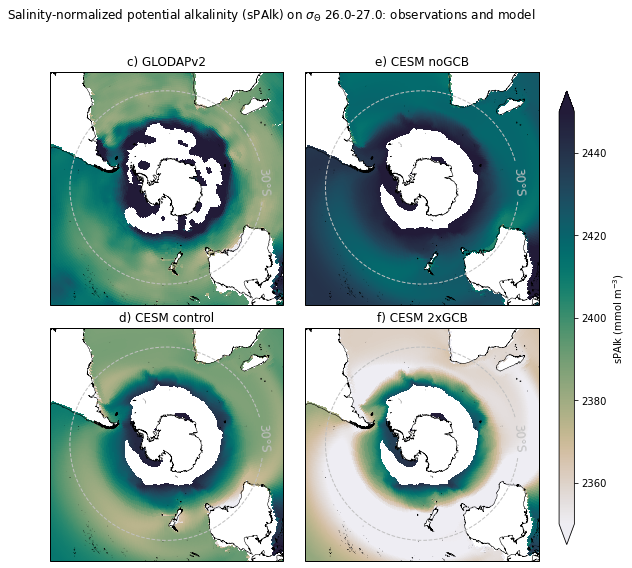

In [60]:
fig = plt.figure(figsize=(8.5,9))
fig.suptitle('Salinity-normalized potential alkalinity (sPAlk) on ${\sigma}_{\Theta}$ 26.0-27.0: observations and model', fontsize=12)
alk_min=2350
alk_max=2450
contour_specs = {'levels': [26.0,27.0]}

#---------- spALK from glodap -----------------------------------------------------------------
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

# #################### make it a circle
#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)
# #################### end circle

ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) GLODAPv2')
pc=ax.pcolormesh(wrap_lon, ds_sigma.lat, 
                 wrap_data, 
                 vmin=alk_min, vmax=alk_max, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)

######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='silver',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '30°S'
plt.clabel(cs_lat, colors = 'silver', fmt = fmt, fontsize=12)
########################

#---------- spAlk from cesm no calc -----------------------------------------------------------------
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('e) CESM noGCB')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

# #################### make it a circle
#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)

# #################### end circle
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, field_spalk_noGCB, cmap=cmocean.cm.rain,
                 vmin=alk_min, vmax=alk_max, 
                  transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)

######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='silver',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '30°S'
plt.clabel(cs_lat, colors = 'silver', fmt = fmt, fontsize=12)
########################


#---------- spAlk from cesm control -----------------------------------------------------------------
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('d) CESM control')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

# #################### make it a circle
#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, field_spalk, cmap=cmocean.cm.rain,
                 vmin=alk_min, vmax=alk_max, 
                  transform=ccrs.PlateCarree())

######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='silver',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '30°S'
plt.clabel(cs_lat, colors = 'silver', fmt = fmt, fontsize=12)
########################


#---------- spAlk from cesm 2x calc -----------------------------------------------------------------
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('f) CESM 2xGCB')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

# #################### make it a circle
#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, field_spalk_2xGCB, cmap=cmocean.cm.rain,
                vmin=alk_min, vmax=alk_max, 
                 transform=ccrs.PlateCarree())


######### add lat lines
cs_lat = ax.contour(ds.lon.values,ds.lat.values,lat_grd,
                colors='silver',
                levels = [-30.],
                linewidths = 1,
                transform=ccrs.PlateCarree())

fmt = '30°S'
plt.clabel(cs_lat, colors = 'silver', fmt = fmt, fontsize=12)
########################



#spAlk color bar
fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)
cbar_ax = fig.add_axes([0.97, 0.15, 0.025, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='sPAlk (mmol m$^{-3}$)',extend='both') #,ticks=np.arange(0,0.3,0.02))#,aspect=50)

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Fig3_rightside.png', dpi=500, bbox_inches='tight',format='png');


### Look at zonal means

In [60]:
sPAlk_glodap_zonal = ds.sPAlk_mmolm3.mean(dim='lon')

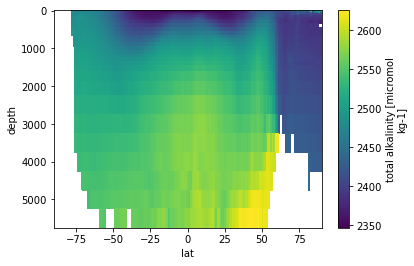

In [61]:
sPAlk_glodap_zonal.plot(yincrease=False)

In [62]:
lats = ds.lat

In [81]:
lats

<xarray.DataArray 'lat' (lat: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [63]:
ds.depth.shape

(33,)

In [64]:
z_top = ds.depth[0:19]

In [65]:
z_bottom = ds.depth[19:33]

In [66]:
sPAlk_glodap_zonal_top = sPAlk_glodap_zonal.isel(depth=slice(0,19))
sPAlk_glodap_zonal_bottom = sPAlk_glodap_zonal.isel(depth=slice(19,33))

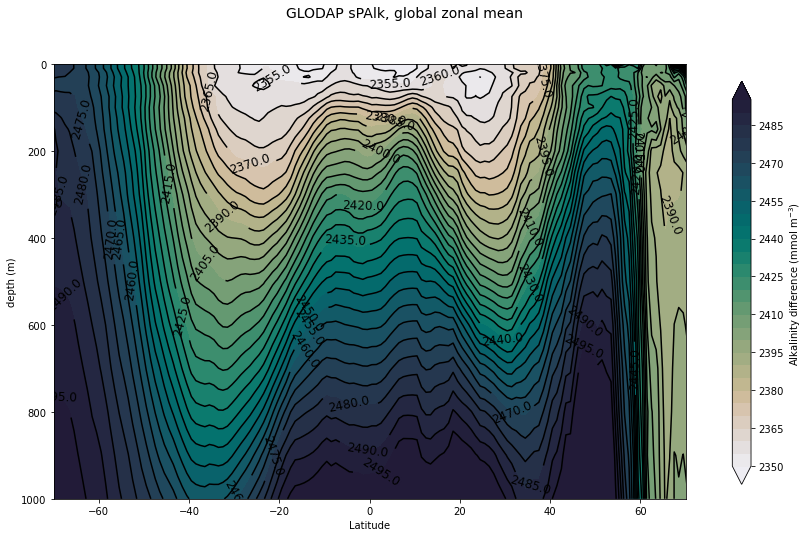

In [83]:
levels = np.arange(2350,2500,5)
fig = plt.figure(figsize=(13,8))

plt.suptitle('GLODAP sPAlk, global zonal mean', fontsize=14)

ax = fig.add_subplot(1,1,1)

pc=ax.contourf(lats, z_top, sPAlk_glodap_zonal_top, levels, cmap=cmocean.cm.rain,extend='both')
contour = plt.contour(lats, z_top, sPAlk_glodap_zonal_top, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)' , xlabel='Latitude',xlim=(-70,70))
ax.invert_yaxis()
#ax.xaxis.tick_top()

# ax = fig.add_subplot(2,1,2)
# pc=ax.contourf(lats, z_bottom, sPAlk_glodap_zonal_bottom, levels, cmap=cmocean.cm.rain,extend='both')
# contour = plt.contour(lats, z_bottom, sPAlk_glodap_zonal_bottom, levels, colors='k')
# plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
# ax.set(ylabel='depth (m)', xlabel='Latitude')
# ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol m$^{-3}$)',extend='both')
#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/atlantic_zonal2.png', bbox_inches='tight', dpi=600);

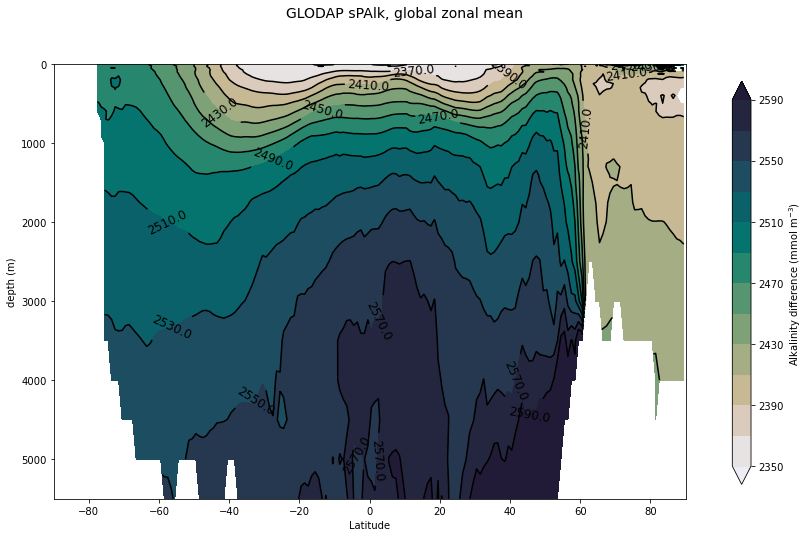

In [84]:
levels = np.arange(2350,2600,20)
fig = plt.figure(figsize=(13,8))

plt.suptitle('GLODAP sPAlk, global zonal mean', fontsize=14)

ax = fig.add_subplot(1,1,1)

pc=ax.contourf(lats, ds.depth, sPAlk_glodap_zonal, levels, cmap=cmocean.cm.rain,extend='both')
contour = plt.contour(lats, ds.depth, sPAlk_glodap_zonal, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)' , xlabel='Latitude',xlim=(-90,90))
ax.invert_yaxis()
#ax.xaxis.tick_top()

fig.subplots_adjust(right=0.8,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol m$^{-3}$)',extend='both')
#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/atlantic_zonal2.png', bbox_inches='tight', dpi=600);

### how many mols of CaCO3 are there in each dataset?

In [72]:
ds_pic.pic.where(ds_sst.sst>2.)*1000

<xarray.DataArray 'pic' (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
Attributes:
    long_name:     Calcite Concentration, Balch and Gordon
    units:         mol m^-3
    actual_range:  [1.21238600e-05 2.42913105e-02]

In [73]:
ds_pic

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
Data variables:
    pic      (lat, lon) float32 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        MODIS Level-3 Standard Mapped Image
    history:      grdmath total.nc 16 DIV = mean_PIC_annual_2002-2017_molm3.nc
    GMT_version:  4.5.18 [64-bit]

In [74]:
area = xr.DataArray(np.zeros([2160,4320]), dims=('lat','lon'))

In [75]:
j=0

for lat in ds_pic.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds_pic['area']=area*1000000. #converting to m2

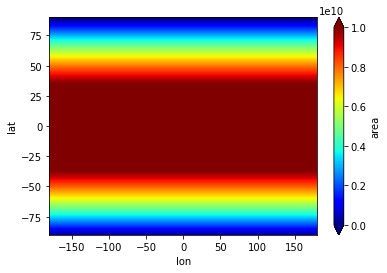

In [76]:
ds_pic.area.plot(cmap='jet',vmin=0,vmax=10e9)

In [77]:
area_m2 = area/10000.

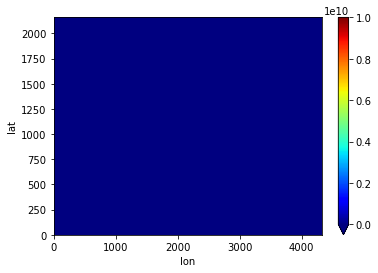

In [78]:
area_m2.plot(cmap='jet',vmin=0,vmax=10e9)

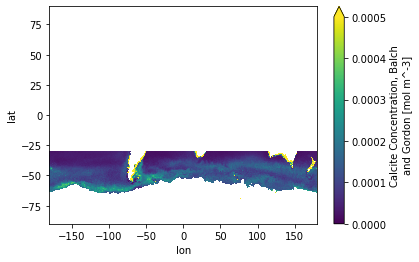

In [79]:
pic_SO_mol = ds_pic.pic.where(ds_sst.sst>2.).where(ds_pic.lat<-30.)
pic_SO_mol.plot(vmin=0,vmax=0.0005)

In [80]:
pic_sum = pic_SO_mol * ds_pic.area

pic_sum = pic_sum.sum(dim=('lon','lat'))

In [81]:
pic_sum.values

array(1.39421037e+12)

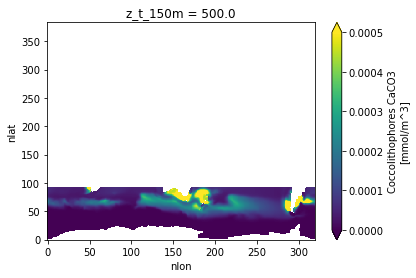

In [82]:
cesm_caco3_sum = ds_annmean.coccoCaCO3.isel(z_t_150m=0).where(ds_annmean.TLAT<-30.)/1000.
cesm_caco3_sum.plot(vmin=0,vmax=0.0005)

In [83]:
#sum CESM coccoCaCO3 in 1 meter deep of seawater

cesm_caco3_sum = cesm_caco3_sum * area_m2
cesm_caco3_sum = cesm_caco3_sum.sum(dim=('nlon','nlat'))

MemoryError: Unable to allocate 8.34 TiB for an array with shape (384, 320, 2160, 4320) and data type float64

In [ ]:
cesm_caco3_sum.values